# Introdução

Este código foi feito em Python 2.

Os resultados da execução deste notebook são:

1. Arquivo sp.csv, contendo o Potencial e Faturamento preditos para São Paulo, a partir da base do Rio de Janeiro.
2. Arquivos segment_00.csv, segment_01.csv, ..., segment_08.csv, contendo as segmentações por classe econômica e idade para os bairros de São Paulo.

In [167]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import fancyimpute
import statsmodels.api as sm
import hdbscan
import seaborn as sns
from statsmodels.imputation.mice import MICE, MICEData
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.svm import SVC, SVR
from sklearn.ensemble import AdaBoostClassifier
from sklearn.manifold import t_sne
from sklearn import manifold
from sklearn.decomposition import PCA
from scipy import stats

In [2]:
df = pd.read_csv('data/input2.csv', sep=u',', low_memory=False)

In [3]:
df.columns

Index([u'codigo', u'nome', u'cidade', u'estado', u'populacao', u'popAte9',
       u'popDe10a14', u'popDe15a19', u'popDe20a24', u'popDe25a34',
       u'popDe35a49', u'popDe50a59', u'popMaisDe60', u'domiciliosA1',
       u'domiciliosA2', u'domiciliosB1', u'domiciliosB2', u'domiciliosC1',
       u'domiciliosC2', u'domiciliosD', u'domiciliosE', u'rendaMedia',
       u'faturamento', u'potencial'],
      dtype='object')

# Análise de missing values

In [4]:
dfm = df.drop(['potencial', 'faturamento'], axis=1)
dfm[dfm.isnull().any(axis=1)]

,codigo,nome,cidade,estado,populacao,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia
6,3304557082,Anil,Rio de Janeiro,RJ,24855,2427,1227,1777,1804,3730,...,4761,355,759,1771,1863,1902,1155,326,424,NaN
26,3304557005,Catumbi,Rio de Janeiro,RJ,12910,1773,805,1018,999,1985,...,2288,0,18,261,640,1281,1140,229,703,NaN
52,3304557086,Freguesia (Jacarepaguá),Rio de Janeiro,RJ,72501,7991,3709,5257,5159,10923,...,12980,698,2569,6042,4941,5055,3919,704,1670,NaN
71,3304557146,Jacaré,Rio de Janeiro,RJ,9538,1326,629,763,712,1547,...,1532,0,15,161,492,633,792,197,540,NaN
89,3304557032,Maracanã,Rio de Janeiro,RJ,25969,1696,843,1370,1921,4020,...,6861,739,1695,3191,1924,1522,877,0,497,NaN
122,3304557006,Rio Comprido,Rio de Janeiro,RJ,44998,5332,2397,3448,3757,7160,...,8002,0,387,2119,2775,3715,3930,617,1681,NaN
232,355030170,Eta Guaraú,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
361,355030227,Pico Do Jaraguá,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
376,355030167,Reserva Da Cantareira,São Paulo,SP,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


Aparentemente, apenas a coluna *rendaMedia* possui missing values:

In [5]:
dfm = df.drop(['potencial', 'faturamento', 'rendaMedia'], axis=1)
dfm[dfm.isnull().any(axis=1)]

,codigo,nome,cidade,estado,populacao,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE


### Removendo bairros de SP que estão sem dados

In [6]:
for p in ['Eta Guaraú', 'Pico Do Jaraguá', 'Reserva Da Cantareira']:
    print any(df['nome'] == p)

True
True
True


In [7]:
df = df.drop([232, 361, 376])

In [8]:
for p in ['Eta Guaraú', 'Pico Do Jaraguá', 'Reserva Da Cantareira']:
    print any(df['nome'] == p)

False
False
False


# Boxplot da renda média agrupada por potencial

In [171]:
def boxplot_groupby(df, filename, column, by, ylim=None):
    """Gera um boxplot
    
    Args:
        df: dataframe pandas
        column: nome da coluna cujo valor será mostrado no boxplot
        by: nome da coluna pelo qual será feito o agrupamento
        ylim: tupla com o limite inferior e superior de y
    """
    fig, ax = plt.subplots()
    df.boxplot(column=column, by=by, ax=ax, showfliers=True, sym='k.')
    if ylim is not None:
        ax.set_ylim(ylim)
        
    filename = 'images/{}.pdf'.format(filename)
    if os.path.isfile(filename):
        raise Exception('Arquivo {} já existe.'.format(filename))
    plt.savefig(filename)    

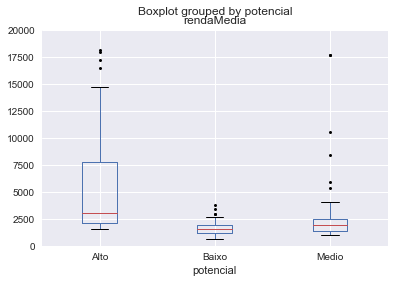

In [173]:
boxplot_groupby(df[df['estado'] == 'RJ'], 'rendamedia', 'rendaMedia', 'potencial', [0, 20000])

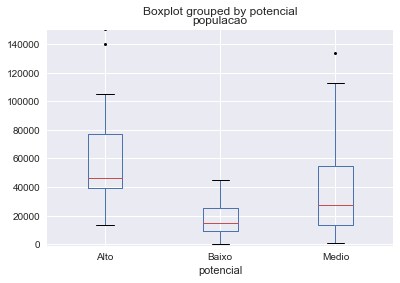

In [174]:
boxplot_groupby(df[df['estado'] == 'RJ'], 'populacao', 'populacao', 'potencial', [-1000, 150000])

# Normalizando população por idade e domicílios por classe econômica para o intervalo [0, 1]

In [12]:
pop = [u'popAte9',  
       u'popDe10a14', 
       u'popDe15a19', 
       u'popDe20a24',
       u'popDe25a34', 
       u'popDe35a49', 
       u'popDe50a59', 
       u'popMaisDe60']

for p in pop:
    df[p] = df[p] / df['populacao']

In [13]:
dom = [u'domiciliosA1',
       u'domiciliosA2',
       u'domiciliosB1',
       u'domiciliosB2',
       u'domiciliosC1',
       u'domiciliosC2',
       u'domiciliosD',
       u'domiciliosE']

df['total_domicilios'] = df[dom].sum(axis=1)

for d in dom:
    df[d] = df[d] / df['total_domicilios']

# Análise de outliers

#### População

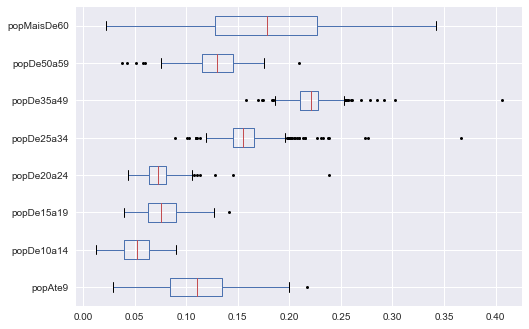

In [14]:
df.boxplot(column=pop, showfliers=True, sym='k.', vert=False)

Apesar de alguns pontos suspeitos, especialmente para *popDe35a59* e *popDe25a34*, as proporções não me parecem fora do normal.

#### Domicílios

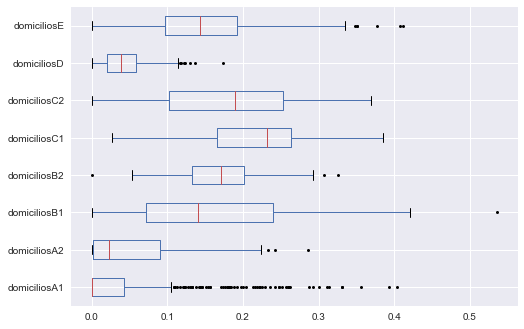

In [15]:
df.boxplot(column=dom, showfliers=True, sym='k.', vert=False)

#### População

Neste caso, a classe A1 aparenta ter um comportamento diferente do das outras, mas isso de certa forma é esperado, dado que representa o topo dentre as classes econômicas.

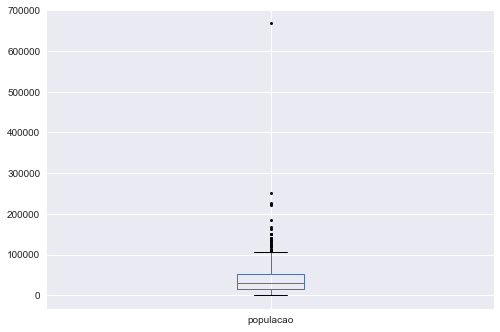

In [16]:
df.boxplot(column=['populacao'], showfliers=True, sym='k.')

In [17]:
df[df['populacao'] > 600000]

,codigo,nome,cidade,estado,populacao,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,total_domicilios
23,3304557102,Campo Grande,Rio de Janeiro,RJ,667603,0.183609,0.083785,0.093382,0.090723,0.128993,...,0.105674,0.191044,0.29786,0.231903,0.044583,0.116442,1856.0,69645.0,Alto,111163


Aqui encontramos algo estranho, visto que a população de Campo Grande, em 2010, era de 328 mil habitantes. O bairro será removido da base.

In [18]:
df = df.drop([23])

#### Renda média

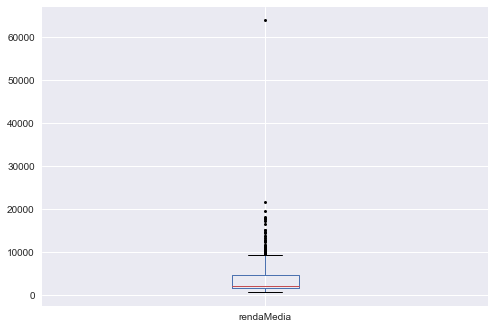

In [19]:
df.boxplot(column=['rendaMedia'], showfliers=True, sym='k.')

In [20]:
df[df['rendaMedia'] > 50000]

,codigo,nome,cidade,estado,populacao,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,total_domicilios
80,3304557021,Lagoa,Rio de Janeiro,RJ,21795,0.082312,0.032485,0.04836,0.057444,0.135031,...,0.218835,0.078989,0.041364,0.034678,0.0,0.05315,63887.0,1775547.0,Alto,8824


Lagoa é um bairro nobre do Rio de Janeiro e é esperado que sua renda média seja superior a de outros bairros. No entanto, uma valor acima de R$ 60.000,00 está longe do que se espera e esse bairro será removido da amostra.

In [21]:
df = df.drop([80])

# Aplicando log para *rendaMedia* e *populacao*

In [22]:
df_norm_log = df.copy()
df_norm_log['rendaMedia'] = np.log(df_norm_log['rendaMedia'])
df_norm_log['populacao'] = np.log(df_norm_log['populacao'])

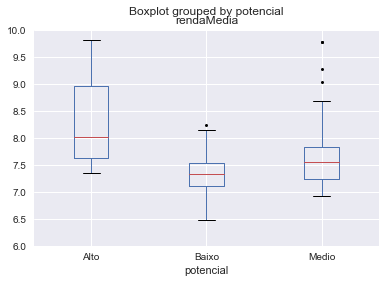

In [175]:
boxplot_groupby(df_norm_log, 'rendamedialog', 'rendaMedia', 'potencial', ylim=[6, 10])

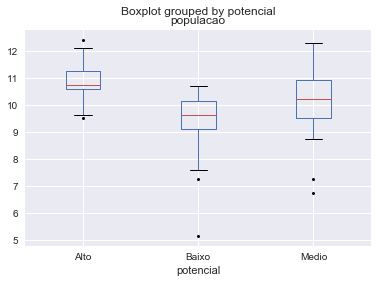

In [176]:
boxplot_groupby(df_norm_log, 'populacaolog', 'populacao', 'potencial')

A renda média maior parece ter associação como um potencial alto para o bairro. O tamanho da população parece ter associação também, mas em um grau bem inferior.

# Aplicando *standardization* para *rendaMedia* e *populacao*

A fórmula para *standardization* é $\frac{X - \mu}{\sigma}$, ou seja, converte-se os dados de maneira que eles tenham média 0 e desvio padrão 1.

In [25]:
df_norm_std = df.copy()
df_norm_std['rendaMedia'] = (df_norm_std['rendaMedia'] - df_norm_std['rendaMedia'].mean()) / df_norm_std['rendaMedia'].std()
df_norm_std['populacao'] = (df_norm_std['populacao'] - df_norm_std['populacao'].mean()) / df_norm_std['populacao'].std()

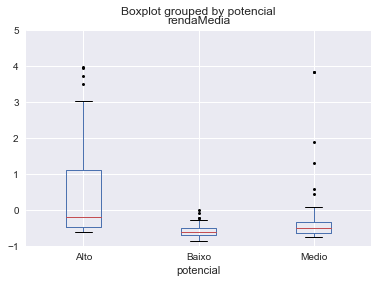

In [180]:
boxplot_groupby(df_norm_std, 'rendamediastd', 'rendaMedia', 'potencial', ylim=[-1, 5])

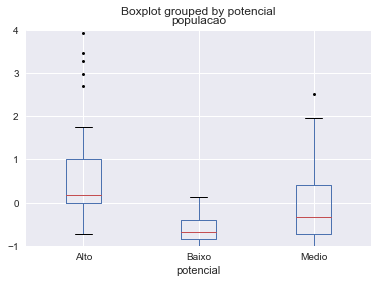

In [182]:
boxplot_groupby(df_norm_std, 'populacaostd', 'populacao', 'potencial', ylim=[-1, 4])

Aqui é mais claro ainda o fato de que uma maior renda está associado com potencial alto.

# Gerando os dataframes para RJ e SP

#### Função para preencher *missing values*  utilizando [Multiple Imputation by Chained Equations](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/).

In [28]:
fml = 'rendaMedia ~ {}' .format(' + '.join(df.columns[5:-3]))
print fml

def fillna(df):
    imp = MICEData(df)
    mice = MICE(fml, sm.OLS, imp)

    results = mice.fit(10, 10)
#     print results.summary()
    return imp.data

rendaMedia ~ popAte9 + popDe10a14 + popDe15a19 + popDe20a24 + popDe25a34 + popDe35a49 + popDe50a59 + popMaisDe60 + domiciliosA1 + domiciliosA2 + domiciliosB1 + domiciliosB2 + domiciliosC1 + domiciliosC2 + domiciliosD + domiciliosE + rendaMedia


In [29]:
df_log_rj = df_norm_log[df_norm_log['estado'] == 'RJ']
df_log_sp = df_norm_log[df_norm_log['estado'] == 'SP']

df_std_rj = df_norm_std[df_norm_std['estado'] == 'RJ']
df_std_sp = df_norm_std[df_norm_std['estado'] == 'SP']

df_rj = df[df['estado'] == 'RJ']
df_sp = df[df['estado'] == 'SP']

In [153]:
X_log_rj = fillna(df_log_rj.iloc[:,4:22])
X_std_rj = fillna(df_std_rj.iloc[:,4:22])
X_rj = fillna(df_rj.iloc[:,4:22])

data = dict()
data['Vanilla'] = X_rj
data['Log normalization'] = X_log_rj
data['Standardization'] = X_std_rj

X_log_sp = df_log_sp.iloc[:,4:22]
X_std_sp = df_std_sp.iloc[:,4:22]

y_faturamento = df_rj[u'faturamento']
y_potencial = df_rj[u'potencial']

# Correlações

#### RJ normalização log

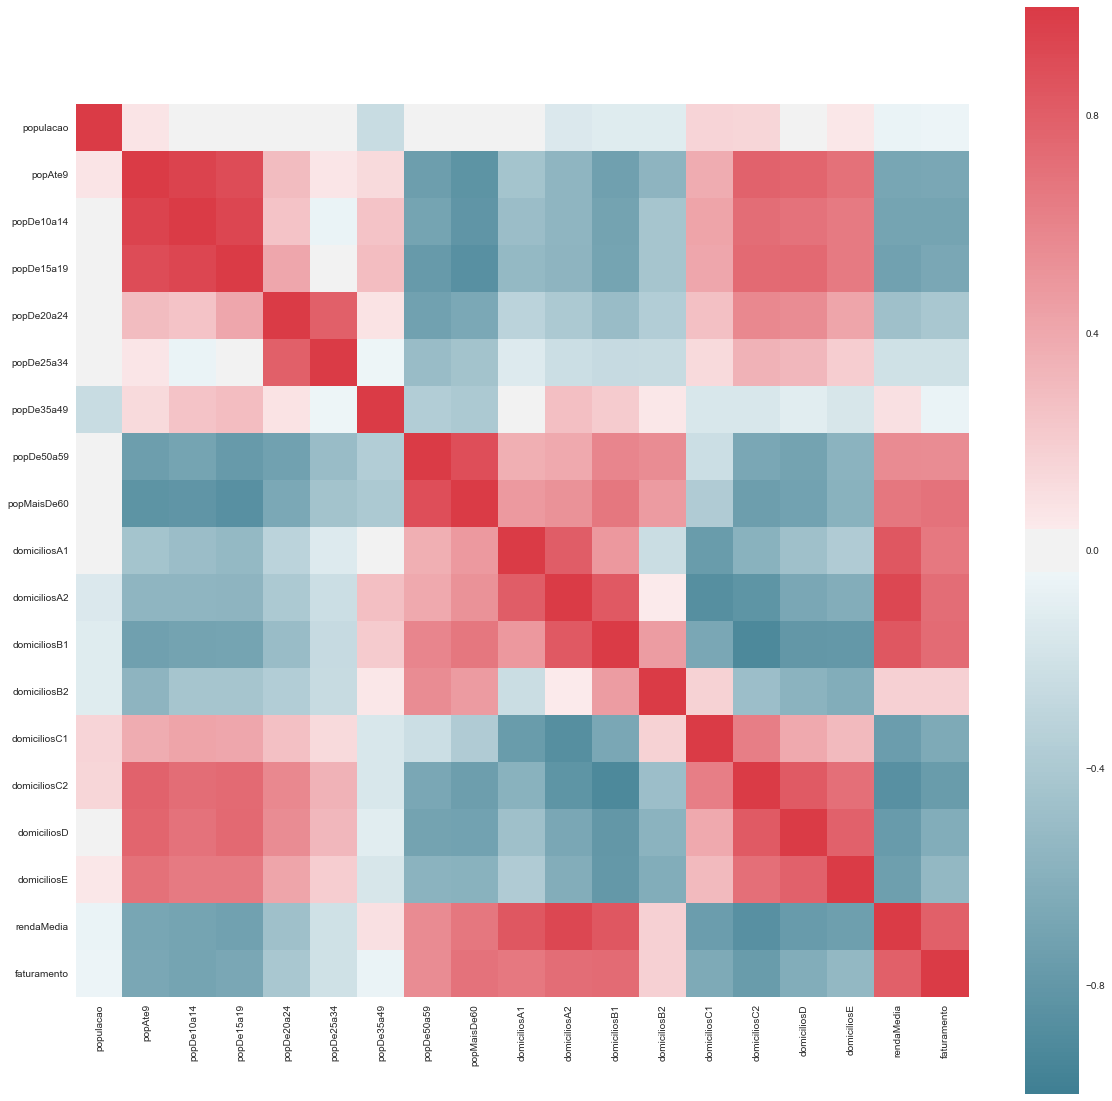

In [31]:
f, ax = plt.subplots(figsize=(20, 20))
corr = df_log_rj.iloc[:,4:24].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

#### RJ normalização *standardization*

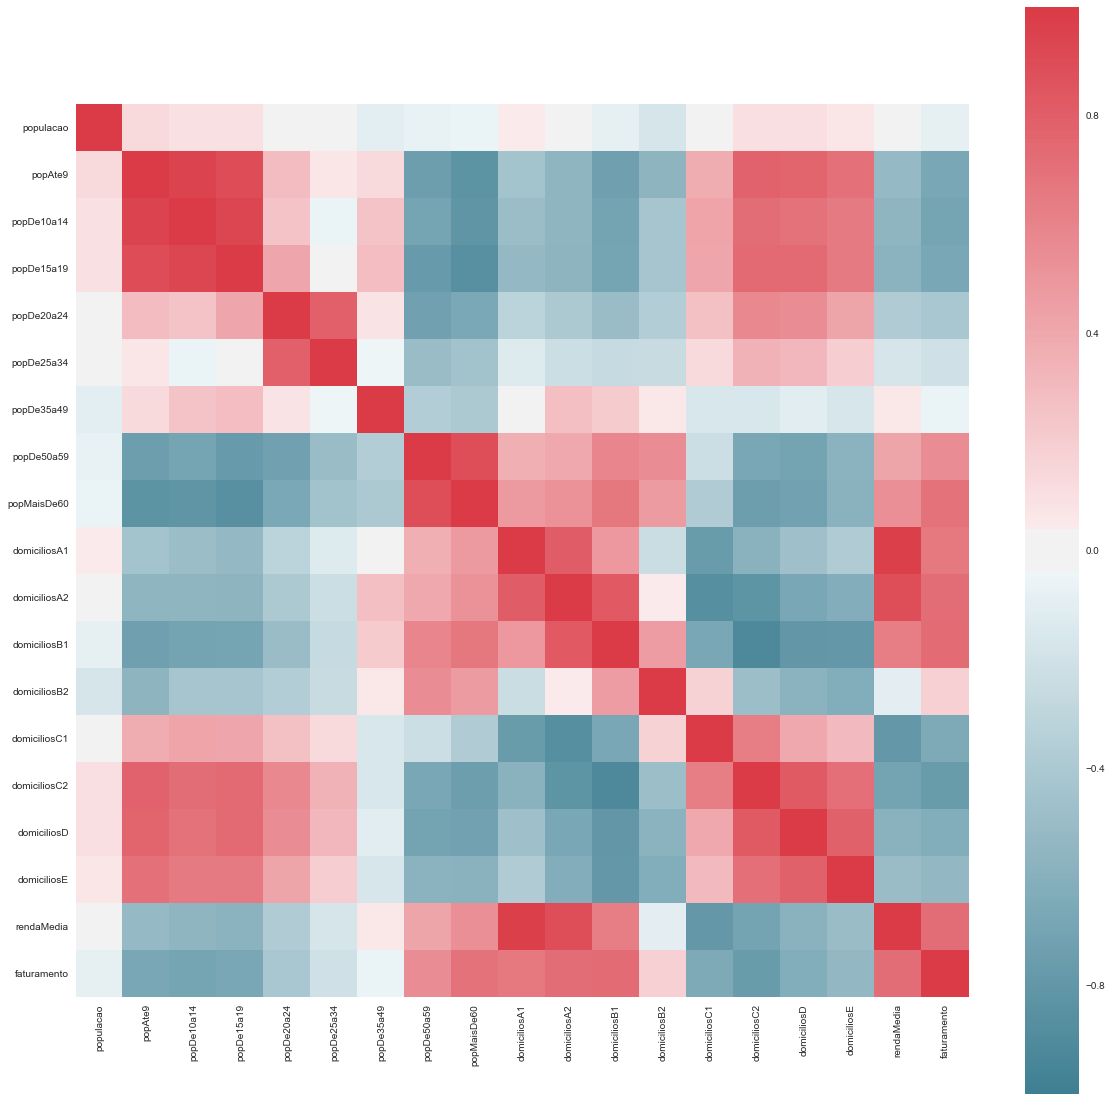

In [32]:
f, ax = plt.subplots(figsize=(20, 20))
corr = df_std_rj.iloc[:,4:24].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

# Redução de dimensionalidade da entrada (fugindo da [maldição da dimensionalidade](https://en.wikipedia.org/wiki/Curse_of_dimensionality))

#### [t-SNE](https://lvdmaaten.github.io/tsne/) - Técnica bastante utilizada para visualização de dados de alta dimensionalidade.

In [33]:
def convert(s):
    if s == 'Medio':
        return 1
    elif s == 'Alto':
        return 2
    else:
        return 0

In [34]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_log_rj_tsne = tsne.fit_transform(X_log_rj)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_std_rj_tsne = tsne.fit_transform(X_std_rj)

data['Log normalization + t-SNE'] = X_log_rj_tsne
data['Standardization + t-SNE'] = X_std_rj_tsne

#### [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) - Ferramenta clássica para redução de dimensionalidade.

In [35]:
pca = PCA(n_components=2)
X_log_rj_pca = pca.fit_transform(X_log_rj)
pca = PCA(n_components=2)
X_std_rj_pca = pca.fit_transform(X_std_rj)

data['Log normalization + PCA'] = X_log_rj_pca
data['Standardization + PCA'] = X_std_rj_pca

# Classificação (Potencial)

In [36]:
def classifier_cv(clf, X, y):    
    scores = cross_val_score(clf, X, y, cv=10)
    print 'score: ', scores.mean()
    
    print confusion_matrix(y_potencial, 
                           cross_val_predict(clf, X, y, cv=10),
                           labels=['Baixo', 'Medio', 'Alto'])
    print ''

#### Resultados

In [37]:
data_keys = [
    'Vanilla',
    'Log normalization', 
    'Log normalization + t-SNE',
    'Log normalization + PCA',
    'Standardization',             
    'Standardization + t-SNE',
    'Standardization + PCA'    
]

In [38]:
clf = SVC()
for label in data_keys:
    print label
    classifier_cv(clf, data[label], y_potencial)

Vanilla
score:  0.392352941176
[[62  0  0]
 [50  0  0]
 [46  0  0]]

Log normalization
score:  0.700857843137
[[58  2  2]
 [22 26  2]
 [ 0 19 27]]

Log normalization + t-SNE
score:  0.392352941176
[[62  0  0]
 [50  0  0]
 [46  0  0]]

Log normalization + PCA
score:  0.861421568627
[[55  4  3]
 [ 9 39  2]
 [ 0  4 42]]

Standardization
score:  0.574730392157
[[60  1  1]
 [32  9  9]
 [10 14 22]]

Standardization + t-SNE
score:  0.392352941176
[[62  0  0]
 [50  0  0]
 [46  0  0]]

Standardization + PCA
score:  0.693406862745
[[57  2  3]
 [21 22  7]
 [ 0 15 31]]



#### XGBoost

In [39]:
clf = XGBClassifier(max_depth=100, learning_rate=0.1)
for label in data_keys:
    print label
    classifier_cv(clf, data[label], y_potencial)

Vanilla
score:  0.783455882353
[[55  5  2]
 [12 29  9]
 [ 0  6 40]]

Log normalization
score:  0.77762254902
[[54  6  2]
 [12 31  7]
 [ 1  7 38]]

Log normalization + t-SNE
score:  0.554411764706
[[39 17  6]
 [17 18 15]
 [ 3 12 31]]

Log normalization + PCA
score:  0.866102941176
[[55  4  3]
 [ 4 42  4]
 [ 1  5 40]]

Standardization
score:  0.77012254902
[[53  7  2]
 [12 30  8]
 [ 0  7 39]]

Standardization + t-SNE
score:  0.626593137255
[[47 10  5]
 [14 24 12]
 [ 4 14 28]]

Standardization + PCA
score:  0.840906862745
[[55  4  3]
 [ 5 39  6]
 [ 2  5 39]]



#### AdaBoost

In [40]:
clf = AdaBoostClassifier(n_estimators=100)
for label in data_keys:
    print label
    classifier_cv(clf, data[label], y_potencial)

Vanilla
score:  0.661691176471
[[34 26  2]
 [ 6 43  1]
 [ 3 15 28]]

Log normalization
score:  0.643725490196
[[31 30  1]
 [ 7 40  3]
 [ 1 14 31]]

Log normalization + t-SNE
score:  0.550147058824
[[40 14  8]
 [16 25  9]
 [10 14 22]]

Log normalization + PCA
score:  0.557181372549
[[14 45  3]
 [ 8 38  4]
 [ 2  8 36]]

Standardization
score:  0.635073529412
[[31 29  2]
 [ 7 41  2]
 [ 4 13 29]]

Standardization + t-SNE
score:  0.551397058824
[[37 18  7]
 [17 25  8]
 [ 5 16 25]]

Standardization + PCA
score:  0.542181372549
[[16 44  2]
 [ 4 43  3]
 [ 5 14 27]]



Classificador foi XGBoost, usando normalização logarítmica + PCA

In [41]:
best_clf = XGBClassifier(max_depth=100, learning_rate=0.1)
best_clf.fit(X_log_rj_pca, y_potencial)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=100,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Regressão (Faturamento)

#### Usando métrica [R2](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [42]:
def regressor_cv(regressor, X, y):
    print 'score: ', cross_val_score(regressor, X, y, scoring='r2', cv=10).mean()
    print ''

In [43]:
regressor = XGBRegressor(max_depth=100, learning_rate=0.1)
%time cross_val_score(regressor, X_rj, y_faturamento, scoring='r2', cv=10).mean()

CPU times: user 4.49 s, sys: 28.8 ms, total: 4.52 s
Wall time: 670 ms


0.88804221784185189

#### XGBoost

In [44]:
regressor = XGBRegressor(max_depth=100, learning_rate=0.1)
for label in data_keys:
    print label
    regressor_cv(regressor, data[label], y_faturamento)

Vanilla
score:  0.888042217842

Log normalization
score:  0.882853853853

Log normalization + t-SNE
score:  -0.460130875839

Log normalization + PCA
score:  0.864002352937

Standardization
score:  0.883722457007

Standardization + t-SNE
score:  -0.106150639368

Standardization + PCA
score:  0.845305244308



#### SVR

In [45]:
regressor = SVR()
for label in data_keys:
    print label
    regressor_cv(regressor, data[label], y_faturamento)

Vanilla
score:  -0.0564918721068

Log normalization
score:  -0.0564701955916

Log normalization + t-SNE
score:  -0.0564918721068

Log normalization + PCA
score:  -0.0564373035537

Standardization
score:  -0.0564771853633

Standardization + t-SNE
score:  -0.0564918721068

Standardization + PCA
score:  -0.0564672408189



Apesar da regressão usando XGBoost com dados sem normalização ter tido o melhor resultado, ele não foi muito diferente daquela executada com normalização log ou *standardization*. Assim sendo, será utilizada a regressão com XGBoost usando *standardization*.

In [98]:
best_regressor = XGBRegressor(max_depth=100, learning_rate=0.1)
best_regressor.fit(X_std_rj, y_faturamento)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=100,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

# Rodando dados para SP

In [100]:
sp_row_index = X_log_sp.index

In [101]:
pca = PCA(n_components=2)
pca.fit(X_log_rj)
X_log_sp_pca = pca.transform(X_log_sp)
df_sp.loc[sp_row_index, 'potencial'] = best_clf.predict(X_log_sp_pca)

In [103]:
df_sp.loc[sp_row_index, 'faturamento'] = best_regressor.predict(X_std_sp)

#### Salvando o CSV

In [104]:
df_sp.to_csv('sp.csv')

#### Faturamento para SP e RJ (mínimo, média, desvio padrão e máximo)

In [105]:
c = df_sp['faturamento']
print c.min(), c.mean(), c.std(), c.max()
c = df_rj['faturamento']
print c.min(), c.mean(), c.std(), c.max()

47324.4 938281.0 418287.0 2.09935e+06
24651.0 875572.170886 430324.404564 2915612.0


In [106]:
new_df = pd.concat([df_rj, df_sp])

#### Boxplot de faturamento por estado

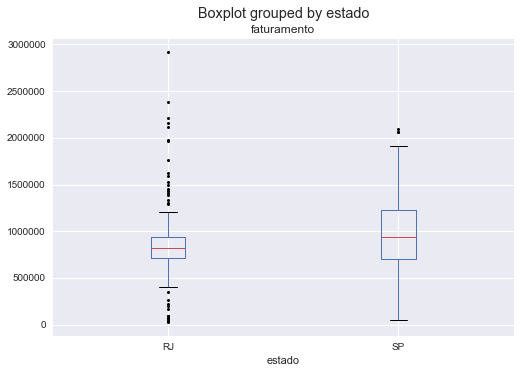

In [107]:
b = new_df.boxplot(column='faturamento', by='estado', showfliers=True, sym='k.')

# Segmentação

#### Calculando a probabilidade conjunta *idade X domicílios* para ser utilizada como *features* na clusterização.

In [108]:
target_populacao_columns = [
    u'popDe25a34',
    u'popDe35a49'
]

In [109]:
target_domicilio_columns = [
    u'domiciliosA1',
    u'domiciliosA2',
    u'domiciliosB1', 
    u'domiciliosB2'
]

In [110]:
df_sp_seg = df_sp.copy()

for p in target_populacao_columns:
    for d in target_domicilio_columns:
        key = '{}_{}'.format(p, d)
        df_sp_seg[key] = df_sp_seg[p] * df_sp_seg[d]
        
df_sp_seg = df_sp_seg.loc[:,u'popDe25a34_domiciliosA1':'popDe35a49_domiciliosB2']

In [111]:
cluster_display_columns = [
    'nome', 
    'popDe25a34', 
    'popDe35a49', 
    'domiciliosA1', 
    'domiciliosA2',
    'domiciliosB1',
    'domiciliosB2',
    'rendaMedia',
    'faturamento',
    'potencial',
    'label'
]

#### HDBSCAN

In [112]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=3)
cluster_labels = clusterer.fit_predict(df_sp_seg)

In [113]:
df_sp.loc[sp_row_index, 'label'] = cluster_labels

In [114]:
df_sp.columns

Index([u'codigo', u'nome', u'cidade', u'estado', u'populacao', u'popAte9',
       u'popDe10a14', u'popDe15a19', u'popDe20a24', u'popDe25a34',
       u'popDe35a49', u'popDe50a59', u'popMaisDe60', u'domiciliosA1',
       u'domiciliosA2', u'domiciliosB1', u'domiciliosB2', u'domiciliosC1',
       u'domiciliosC2', u'domiciliosD', u'domiciliosE', u'rendaMedia',
       u'faturamento', u'potencial', u'total_domicilios', u'label'],
      dtype='object')

In [115]:
df_sp[df_sp.label == 0][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
170,Alto De Pinheiros,0.102908,0.217375,0.313333,0.182963,0.233333,0.093704,12793.0,1164520.875,Medio,0
182,Boçava,0.126797,0.227117,0.222082,0.141796,0.233852,0.122320,9800.0,1460342.375,Alto,0
209,Chácara Flora,0.109344,0.219652,0.287041,0.181154,0.220071,0.125049,11500.0,1306192.375,Alto,0
298,Jardins,0.131307,0.218728,0.259836,0.127108,0.217683,0.112408,11135.0,1261500.250,Medio,0
318,Moema,0.162777,0.239866,0.251223,0.192933,0.238594,0.089270,11332.0,2059578.875,Alto,0
321,Morumbi,0.136388,0.236295,0.259040,0.162031,0.228095,0.101704,14504.0,1275057.375,Alto,0
326,Pacaembu,0.110124,0.199880,0.331248,0.141106,0.223167,0.094571,15057.0,1181979.625,Medio,0
348,Parque Ibirapuera,0.134936,0.224821,0.225182,0.216949,0.266828,0.097337,11613.0,1160149.625,Medio,0
403,Trianon,0.141886,0.212026,0.256345,0.139023,0.261421,0.108947,12550.0,1491125.500,Alto,0
406,Viera De Morais,0.143622,0.213711,0.243018,0.158831,0.245429,0.119550,13650.0,1473784.625,Alto,0


In [116]:
df_sp[df_sp.label == 1][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
176,Bandeirantes,0.162006,0.230247,0.181818,0.157134,0.290989,0.099739,8244.0,1227606.000,Medio,1
178,Bela Vista,0.174470,0.205986,0.156663,0.164929,0.302645,0.122838,7887.0,1472971.500,Alto,1
190,Brooklin,0.152673,0.234887,0.192721,0.178852,0.276976,0.114719,8427.0,1434813.375,Alto,1
194,Campo Belo,0.146620,0.213121,0.170564,0.154073,0.305685,0.128476,11047.0,1219067.625,Medio,1
332,Paraíso,0.150027,0.206419,0.235728,0.188049,0.312972,0.109651,11686.0,1454168.375,Alto,1
385,Santa Cruz,0.172800,0.218157,0.138156,0.159675,0.278300,0.153165,8738.0,1269416.875,Alto,1
433,Vila Madalena,0.179146,0.228570,0.145889,0.145604,0.282209,0.129405,8747.0,1459565.875,Alto,1
436,Vila Mariana,0.160473,0.197637,0.155972,0.150644,0.302049,0.148946,10575.0,1491940.375,Alto,1


In [117]:
df_sp[df_sp.label == 2][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
221,Cidade Vargas,0.160721,0.228597,0.029758,0.085115,0.278604,0.183939,3893.0,1176148.750,Alto,2
250,Independência,0.140214,0.226073,0.052972,0.084307,0.307759,0.190873,5616.0,1423306.250,Alto,2
363,Piqueri/Parque São Jorge,0.153176,0.242271,0.047341,0.102344,0.274564,0.192768,4897.0,1790718.875,Alto,2


In [118]:
df_sp[df_sp.label == 3][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
340,Parque Continental,0.164515,0.223079,0.030806,0.080716,0.271642,0.219701,4276.0,1.169650e+06,Alto,3
368,Ponte Transamérica,0.150817,0.221889,0.021804,0.082736,0.285544,0.233871,4129.0,9.913925e+05,Medio,3
389,Santana,0.145230,0.201006,0.038565,0.085615,0.302738,0.234863,5656.0,9.963374e+05,Medio,3
404,Tucuruvi,0.127696,0.204223,0.028040,0.093573,0.309546,0.246219,4198.0,1.205642e+06,Alto,3


In [119]:
df_sp[df_sp.label == 4][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
262,Jardim Anália Franco,0.126264,0.226808,0.057215,0.098070,0.219883,0.179530,4295.0,1368973.75,Alto,4
271,Jardim Da Glória,0.129872,0.205889,0.055272,0.119615,0.250000,0.180556,5347.0,1158153.25,Medio,4
448,Vila Santa Catarina,0.163259,0.239448,0.046174,0.080275,0.208326,0.146097,4148.0,1396871.50,Alto,4


In [120]:
df_sp[df_sp.label == 5][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
165,Água Rasa,0.138708,0.223349,0.057617,0.089260,0.243970,0.196454,5907.0,1407971.25,Alto,5
322,Nazaré - Alto Do Ipiranga,0.144383,0.221216,0.045260,0.084001,0.246235,0.203147,4675.0,1408717.50,Alto,5
445,Vila Prudente,0.138317,0.224652,0.037732,0.090803,0.225300,0.197383,4497.0,1223035.25,Alto,5
451,Vila Sônia,0.134435,0.221867,0.078743,0.091031,0.239572,0.185489,5285.0,1410869.25,Alto,5


In [121]:
df_sp[df_sp.label == 6][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
167,Alfredo Pujol,0.138158,0.215136,0.099159,0.127135,0.290466,0.181303,6586.0,1490989.875,Alto,6
272,Jardim Da Saúde,0.125340,0.213999,0.085942,0.102416,0.269495,0.180258,5532.0,1466372.625,Alto,6
296,Jardim São Paulo,0.131904,0.213205,0.078997,0.113388,0.295494,0.176094,6510.0,1491919.125,Alto,6
417,Vila Cordeiro,0.140131,0.211546,0.083173,0.124279,0.280288,0.170192,6544.0,1239044.625,Medio,6


In [122]:
df_sp[df_sp.label == 7][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
277,Jardim Domingos,0.150830,0.228995,0.021167,0.061763,0.199189,0.205192,3113.0,1105600.375,Alto,7
324,Oratório,0.138637,0.221204,0.023955,0.057727,0.196326,0.197136,3694.0,1132054.000,Alto,7
415,Vila Carrão,0.133596,0.216505,0.015379,0.034081,0.188583,0.198814,2822.0,987666.625,Alto,7


In [123]:
df_sp[df_sp.label == 8][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
319,Moinho Velho,0.163495,0.222065,0.012114,0.032820,0.207306,0.217751,2921.0,1.013232e+06,Alto,8
330,Parada Inglesa,0.148608,0.215712,0.014255,0.042981,0.242981,0.212887,3073.0,1.158098e+06,Alto,8
401,Tiquatira,0.143145,0.228227,0.000000,0.031677,0.216890,0.232634,2598.0,1.014014e+06,Alto,8
425,Vila Gustavo,0.142757,0.211878,0.003657,0.037615,0.238173,0.233006,2774.0,1.107908e+06,Alto,8


In [124]:
df_sp[df_sp.label == 9][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
160,A. E. Carvalho,0.154572,0.229162,0.000000,0.008900,0.077286,0.153657,1501.0,353892.781250,Medio,9
162,Adventista,0.170347,0.224238,0.000000,0.000000,0.042024,0.143967,1284.0,225928.015625,Medio,9
164,Água Funda,0.152591,0.222050,0.000000,0.018861,0.111671,0.185870,1905.0,849837.937500,Alto,9
166,Águia De Haia,0.146969,0.219286,0.000000,0.004034,0.120430,0.177540,1729.0,756280.187500,Alto,9
173,Aricanduva,0.140423,0.221371,0.005292,0.015510,0.149504,0.198163,2313.0,957550.750000,Alto,9
177,Barra Funda,0.143750,0.212500,0.018182,0.027273,0.127273,0.218182,1956.0,848834.500000,Baixo,9
183,Bom Retiro,0.175289,0.206222,0.000000,0.016715,0.114354,0.143009,1598.0,869725.437500,Baixo,9
185,Bororé,0.144050,0.213489,0.000000,0.000000,0.019165,0.111596,1054.0,700538.625000,Baixo,9
188,Brasilândia,0.148516,0.224993,0.000000,0.000000,0.105750,0.210986,1764.0,642367.812500,Alto,9
189,Bresser,0.199757,0.222993,0.000000,0.020064,0.111465,0.170064,1796.0,818079.937500,Baixo,9


In [125]:
df_sp[df_sp.label == -1][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
161,Aclimação,0.162880,0.222043,0.101779,0.124901,0.266801,0.169344,5920.0,1.452650e+06,Alto,-1
163,Água Branca,0.168383,0.222703,0.110540,0.118158,0.275996,0.182817,6278.0,1.201059e+06,Alto,-1
168,Alto Da Lapa,0.126487,0.228731,0.142131,0.139759,0.251567,0.158225,8303.0,1.258648e+06,Alto,-1
169,Alto Da Mooca,0.128934,0.225852,0.043149,0.111159,0.307187,0.192170,4841.0,1.436357e+06,Alto,-1
171,Ana Rosa,0.195307,0.217807,0.088267,0.139644,0.322400,0.134489,6075.0,1.449000e+06,Alto,-1
172,Anhanguera,0.138548,0.284856,0.000000,0.000000,0.059918,0.185594,1522.0,7.515226e+05,Baixo,-1
174,Armênia,0.196104,0.200130,0.000000,0.018843,0.133244,0.168237,1795.0,8.751472e+05,Baixo,-1
175,Artur Alvim,0.161576,0.214460,0.000000,0.000000,0.107370,0.243190,1821.0,6.589472e+05,Alto,-1
179,Belém,0.144975,0.212560,0.039825,0.090971,0.246727,0.238680,4366.0,1.159089e+06,Alto,-1
180,Berrini - Vila Funchal,0.232263,0.253206,0.180211,0.180211,0.271240,0.094195,10313.0,1.127531e+06,Medio,-1


#### KMeans

In [126]:
from sklearn.cluster import KMeans

In [127]:
kmeans = KMeans(n_clusters=9, random_state=0).fit_predict(df_sp_seg)

In [129]:
df_sp.loc[sp_row_index, 'label'] = kmeans

In [130]:
df_sp[df_sp.label == 0][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
179,Belém,0.144975,0.212560,0.039825,0.090971,0.246727,0.238680,4366.0,1.159089e+06,Alto,0
181,Bexiga,0.204678,0.228649,0.017975,0.048588,0.203406,0.216583,3211.0,9.932348e+05,Alto,0
193,Cambuci,0.178525,0.227160,0.025318,0.053399,0.251803,0.196103,3946.0,9.869111e+05,Medio,0
195,Campo Grande,0.167695,0.239228,0.000000,0.040504,0.236438,0.185197,2493.0,9.979451e+05,Alto,0
221,Cidade Vargas,0.160721,0.228597,0.029758,0.085115,0.278604,0.183939,3893.0,1.176149e+06,Alto,0
238,Freguesia Do Ó,0.147716,0.223782,0.005828,0.059749,0.237195,0.201658,2981.0,1.201535e+06,Alto,0
241,Glicério,0.175456,0.237869,0.042178,0.080833,0.223171,0.194875,3947.0,1.146450e+06,Baixo,0
252,Ipiranga,0.132993,0.224509,0.015045,0.072895,0.243410,0.247842,3427.0,1.205516e+06,Medio,0
256,Jabaquara,0.162183,0.221224,0.004767,0.052725,0.288886,0.193397,3017.0,1.141410e+06,Alto,0
306,Lapa De Baixo,0.150265,0.196111,0.019643,0.047749,0.271683,0.213962,3633.0,9.534594e+05,Medio,0


In [131]:
df_sp[df_sp.label == 1][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
187,Brás,0.173606,0.234194,0.000000,0.026224,0.191215,0.281469,2409.0,8.801797e+05,Medio,1
192,Cachoeirinha,0.157551,0.227419,0.000000,0.022411,0.168029,0.216866,2224.0,8.634348e+05,Alto,1
197,Cangaíba,0.142817,0.227840,0.000000,0.009465,0.157291,0.224312,2048.0,8.386541e+05,Alto,1
204,Casa Verde Alta,0.151779,0.215122,0.000000,0.032698,0.170460,0.217215,2297.0,9.577531e+05,Alto,1
213,Cidade Ademar,0.156114,0.227411,0.008363,0.053059,0.185659,0.188062,6429.0,1.120463e+06,Alto,1
228,Emissário,0.181996,0.254452,0.031290,0.068327,0.182631,0.176884,3382.0,9.590095e+05,Baixo,1
248,Horto Florestal,0.146719,0.250621,0.015432,0.041005,0.204145,0.224427,3157.0,9.314214e+05,Baixo,1
277,Jardim Domingos,0.150830,0.228995,0.021167,0.061763,0.199189,0.205192,3113.0,1.105600e+06,Alto,1
284,Jardim Maria Do Carmo,0.199183,0.211097,0.006954,0.055999,0.191153,0.157124,2558.0,8.737756e+05,Alto,1
291,Jardim Providência,0.160210,0.206347,0.026432,0.052865,0.198179,0.160870,3120.0,1.089673e+06,Medio,1


In [132]:
df_sp[df_sp.label == 2][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
176,Bandeirantes,0.162006,0.230247,0.181818,0.157134,0.290989,0.099739,8244.0,1227606.000,Medio,2
178,Bela Vista,0.174470,0.205986,0.156663,0.164929,0.302645,0.122838,7887.0,1472971.500,Alto,2
180,Berrini - Vila Funchal,0.232263,0.253206,0.180211,0.180211,0.271240,0.094195,10313.0,1127531.250,Medio,2
182,Boçava,0.126797,0.227117,0.222082,0.141796,0.233852,0.122320,9800.0,1460342.375,Alto,2
190,Brooklin,0.152673,0.234887,0.192721,0.178852,0.276976,0.114719,8427.0,1434813.375,Alto,2
194,Campo Belo,0.146620,0.213121,0.170564,0.154073,0.305685,0.128476,11047.0,1219067.625,Medio,2
202,Cardoso De Almeida,0.137728,0.195897,0.218733,0.195942,0.322679,0.087549,11365.0,1154684.000,Medio,2
210,Chácara Itaim,0.167578,0.209917,0.292885,0.152825,0.288388,0.090593,12424.0,1482382.375,Alto,2
211,Chácara Klabin,0.146268,0.251975,0.261952,0.193201,0.257702,0.105934,13218.0,1423251.375,Alto,2
237,Fazenda Morumbi,0.189939,0.235870,0.176702,0.106348,0.182919,0.107003,10252.0,1129926.250,Medio,2


In [133]:
df_sp[df_sp.label == 3][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
162,Adventista,0.170347,0.224238,0.000000,0.000000,0.042024,0.143967,1284.0,225928.015625,Medio,3
185,Bororé,0.144050,0.213489,0.000000,0.000000,0.019165,0.111596,1054.0,700538.625000,Baixo,3
198,Canindé,0.145175,0.169940,0.000000,0.009036,0.093373,0.117470,1482.0,793847.312500,Baixo,3
199,Cantareira,0.109299,0.226754,0.000000,0.000000,0.060811,0.162162,1365.0,793000.625000,Baixo,3
201,Capivari - Monos,0.113002,0.210007,0.000000,0.000000,0.006438,0.109442,857.0,744058.125000,Baixo,3
208,Centro Empresarial,0.172723,0.229984,0.000000,0.002064,0.054452,0.135122,1324.0,151228.625000,Medio,3
219,Cidade Tiradentes,0.161683,0.213441,0.000000,0.000000,0.019862,0.114680,1123.0,47324.382812,Medio,3
223,Cocaia,0.164389,0.229237,0.000000,0.000000,0.023437,0.108647,1121.0,48805.792969,Medio,3
224,Cohab Jova Rural,0.165773,0.214811,0.000000,0.000000,0.040236,0.137822,1294.0,587169.625000,Baixo,3
227,Cratera - Colônia,0.146881,0.226925,0.000000,0.000000,0.000000,0.070180,843.0,649962.187500,Baixo,3


In [134]:
df_sp[df_sp.label == 4][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
170,Alto De Pinheiros,0.102908,0.217375,0.313333,0.182963,0.233333,0.093704,12793.0,1164520.875,Medio,4
209,Chácara Flora,0.109344,0.219652,0.287041,0.181154,0.220071,0.125049,11500.0,1306192.375,Alto,4
278,Jardim Europa,0.100890,0.215990,0.392783,0.137132,0.233618,0.071035,21677.0,1913580.250,Alto,4
282,Jardim Lusitânia,0.109693,0.205201,0.355623,0.176292,0.186930,0.057751,15113.0,1201338.500,Medio,4
298,Jardins,0.131307,0.218728,0.259836,0.127108,0.217683,0.112408,11135.0,1261500.250,Medio,4
300,Jockey Clube,0.120754,0.217543,0.403802,0.106464,0.137643,0.054753,19585.0,1848970.250,Medio,4
321,Morumbi,0.136388,0.236295,0.259040,0.162031,0.228095,0.101704,14504.0,1275057.375,Alto,4
326,Pacaembu,0.110124,0.199880,0.331248,0.141106,0.223167,0.094571,15057.0,1181979.625,Medio,4
374,Real Parque,0.142747,0.243164,0.248268,0.091515,0.125376,0.053079,12706.0,1261871.625,Alto,4
409,Vila Andrade,0.159754,0.269210,0.213874,0.127511,0.180008,0.076531,9020.0,1508571.875,Alto,4


In [135]:
df_sp[df_sp.label == 5][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
163,Água Branca,0.168383,0.222703,0.110540,0.118158,0.275996,0.182817,6278.0,1201059.125,Alto,5
171,Ana Rosa,0.195307,0.217807,0.088267,0.139644,0.322400,0.134489,6075.0,1449000.375,Alto,5
186,Bosque Da Saúde,0.165901,0.244971,0.104316,0.141070,0.266389,0.148483,7899.0,1449012.250,Alto,5
207,Ceasa,0.273054,0.238890,0.077131,0.152458,0.182679,0.100586,5403.0,1115994.250,Medio,5
212,Chácara Santo Antônio,0.180380,0.227690,0.105411,0.166733,0.303808,0.162325,7818.0,1133203.750,Medio,5
220,Cidade Universitária,0.275898,0.195625,0.143876,0.162670,0.274141,0.145820,7179.0,1118396.250,Medio,5
222,Clínicas,0.237669,0.213527,0.132622,0.129098,0.316620,0.146458,8728.0,1422507.375,Alto,5
226,Consolação,0.215178,0.214360,0.065724,0.099183,0.269160,0.181368,5516.0,1415453.875,Alto,5
243,Granja Julieta,0.134419,0.222365,0.121633,0.161524,0.329611,0.165786,8432.0,1496478.750,Alto,5
281,Jardim Jussara,0.161246,0.247716,0.074632,0.112759,0.306628,0.164964,5569.0,1363435.875,Alto,5


In [136]:
df_sp[df_sp.label == 6][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
160,A. E. Carvalho,0.154572,0.229162,0.000000,0.008900,0.077286,0.153657,1501.0,353892.78125,Medio,6
164,Água Funda,0.152591,0.222050,0.000000,0.018861,0.111671,0.185870,1905.0,849837.93750,Alto,6
166,Águia De Haia,0.146969,0.219286,0.000000,0.004034,0.120430,0.177540,1729.0,756280.18750,Alto,6
172,Anhanguera,0.138548,0.284856,0.000000,0.000000,0.059918,0.185594,1522.0,751522.56250,Baixo,6
173,Aricanduva,0.140423,0.221371,0.005292,0.015510,0.149504,0.198163,2313.0,957550.75000,Alto,6
174,Armênia,0.196104,0.200130,0.000000,0.018843,0.133244,0.168237,1795.0,875147.25000,Baixo,6
175,Artur Alvim,0.161576,0.214460,0.000000,0.000000,0.107370,0.243190,1821.0,658947.25000,Alto,6
177,Barra Funda,0.143750,0.212500,0.018182,0.027273,0.127273,0.218182,1956.0,848834.50000,Baixo,6
183,Bom Retiro,0.175289,0.206222,0.000000,0.016715,0.114354,0.143009,1598.0,869725.43750,Baixo,6
188,Brasilândia,0.148516,0.224993,0.000000,0.000000,0.105750,0.210986,1764.0,642367.81250,Alto,6


In [137]:
df_sp[df_sp.label == 7][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
161,Aclimação,0.162880,0.222043,0.101779,0.124901,0.266801,0.169344,5920.0,1452649.625,Alto,7
165,Água Rasa,0.138708,0.223349,0.057617,0.089260,0.243970,0.196454,5907.0,1407971.250,Alto,7
167,Alfredo Pujol,0.138158,0.215136,0.099159,0.127135,0.290466,0.181303,6586.0,1490989.875,Alto,7
168,Alto Da Lapa,0.126487,0.228731,0.142131,0.139759,0.251567,0.158225,8303.0,1258647.500,Alto,7
169,Alto Da Mooca,0.128934,0.225852,0.043149,0.111159,0.307187,0.192170,4841.0,1436357.375,Alto,7
184,Bonfiglioli,0.165430,0.223370,0.059197,0.100574,0.293002,0.172390,4684.0,1413997.875,Alto,7
191,Butantã,0.141624,0.200763,0.109180,0.117796,0.219846,0.193702,5810.0,1478963.625,Alto,7
203,Casa Verde,0.148824,0.222242,0.026130,0.076335,0.265735,0.181758,3862.0,1166962.500,Alto,7
225,Congonhas,0.155858,0.223849,0.049669,0.049669,0.195364,0.125828,4517.0,1026324.625,Medio,7
250,Independência,0.140214,0.226073,0.052972,0.084307,0.307759,0.190873,5616.0,1423306.250,Alto,7


In [138]:
df_sp[df_sp.label == 8][cluster_display_columns]

,nome,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial,label
336,Parque Anhembi,0.209763,0.291557,0.022989,0.078544,0.536398,0.256705,5723.0,962848.125,Medio,8


Os resultados do HDBSCAN não foram muito bons: um dos clusters tem tamanho 115 e outro, de *label* -1 que significa não clusterizado, terminou com 134 elementos.

O KMeans foi executado com K=9, pois o processamento foi feito utilizando 2 proporções de idade (25 a 34 e 34 a 49) e 4 de domicílio (A1, A2, B1, B2), totalizando 8 pares distintos; uma classe a mais foi gerada para agrupar os bairros menos interessantes do ponto de vista da pesquisa.

A segmentação será baseada no resultado do KMeans.

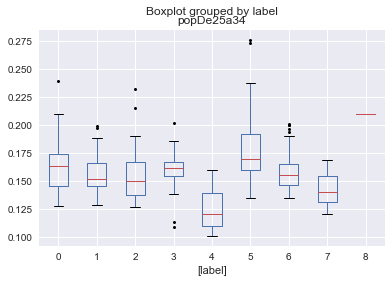

In [186]:
boxplot_groupby(df_sp, 'pop2534', 'popDe25a34', ['label'])

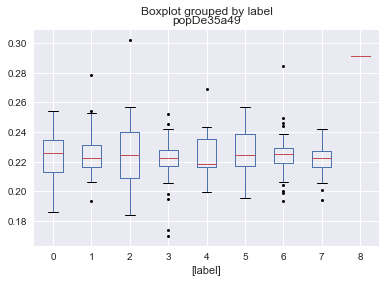

In [187]:
boxplot_groupby(df_sp, 'pop3549', 'popDe35a49', ['label'])

In [141]:
df_sp_seg.loc[sp_row_index, 'label'] = kmeans

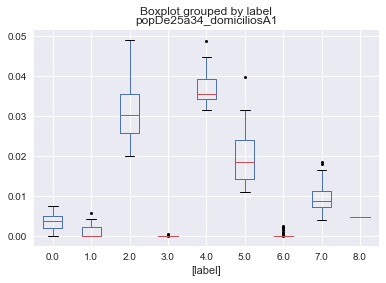

In [188]:
boxplot_groupby(df_sp_seg, 'pop2534a1', 'popDe25a34_domiciliosA1', ['label'])

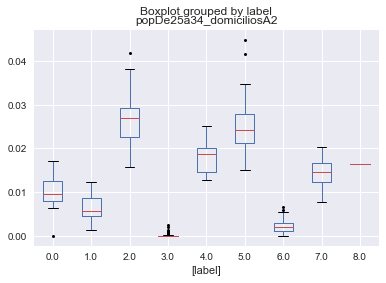

In [189]:
boxplot_groupby(df_sp_seg, 'pop2534a2', 'popDe25a34_domiciliosA2', ['label'])

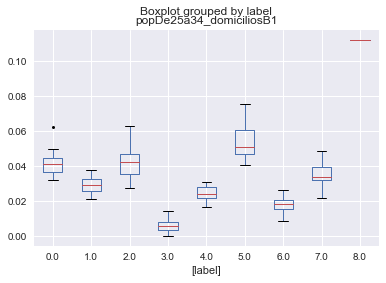

In [190]:
boxplot_groupby(df_sp_seg, 'pop2534b1', 'popDe25a34_domiciliosB1', ['label'])

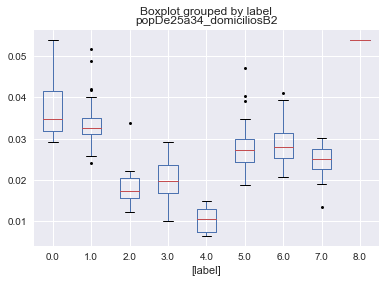

In [191]:
boxplot_groupby(df_sp_seg, 'pop2534b2', 'popDe25a34_domiciliosB2', ['label'])

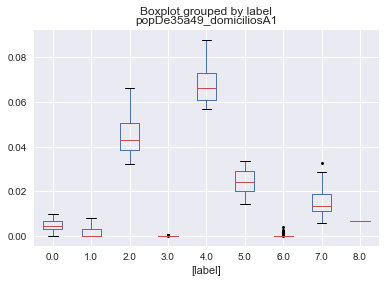

In [192]:
boxplot_groupby(df_sp_seg, 'pop3549a1', 'popDe35a49_domiciliosA1', ['label'])

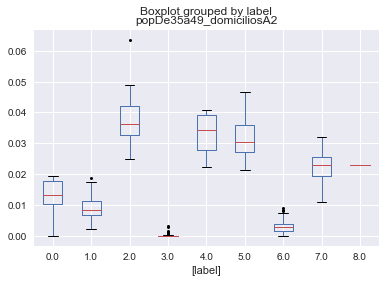

In [193]:
boxplot_groupby(df_sp_seg, 'pop3549a2', 'popDe35a49_domiciliosA2', ['label'])

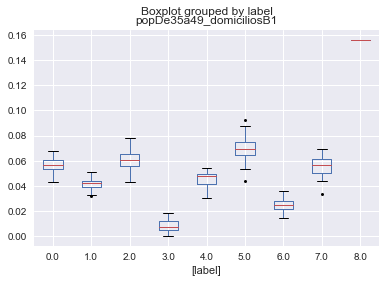

In [194]:
boxplot_groupby(df_sp_seg, 'pop3549b1', 'popDe35a49_domiciliosB1', ['label'])

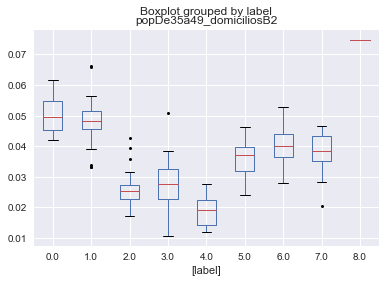

In [195]:
boxplot_groupby(df_sp_seg, 'pop3549b2', 'popDe35a49_domiciliosB2', ['label'])

In [151]:
for i in range(0, 9):
    filename = 'segment_%02d.csv' % (i)
    df_sp[df_sp.label == i].to_csv(filename)

# Conclusões sobre os clusters

- Cluster 0: representatividade na classe B2, para ambas as faixas de idade.
- Cluster 1: representatividade na classe B2 (menor que no cluster 0), para ambas as faixas de idade.
- Cluster 2: representatividade nas classes A1 e A2, para ambas as faixas de idade.
- Cluster 3: é o cluster onde os bairros menos interessantes para investimento.
- Cluster 4: é o cluster com maior proporção de domicílios na classe A1, para ambas as faixas de idade, mas pela análise da marginal *popDe25a34*, abaixo de todas os outros clusters, parece ser mais aderente à faixa de idade 35-49. 
- Cluster 5: representatividade nas classes B1 e A2, para ambas as faixas de idade. Também é relevante para a classe A1 em ambas as faixas de idade.
- Cluster 6: representatividade em B2, para ambas as faixas de idade.
- Cluster 7: representação equilibrada entre todas as classes econômicas e faixas de idade.
- Cluster 8: o bairro do Parque Anhembi, tem uma proporção acima do esperado nas classes B1 e B2, para ambas as faixas de idade.
